In [1]:
import os
import cv2
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd 


In [2]:
def explore_video_dataset_improved(violence_path, non_violence_path, sample_size=100):
    """
    Análisis exploratorio mejorado del dataset de videos con visualizaciones comparativas.
    
    Args:
        violence_path: Ruta a los videos de violencia
        non_violence_path: Ruta a los videos de no violencia
        sample_size: Número de videos a analizar por clase
    """
    print("=== 📊 ANÁLISIS EXPLORATORIO MEJORADO ===")
    
    # Contar archivos
    violence_videos = glob.glob(os.path.join(violence_path, "*.mp4"))
    non_violence_videos = glob.glob(os.path.join(non_violence_path, "*.mp4"))
    
    print(f"\n📹 INFORMACIÓN BÁSICA:")
    print(f"├── Videos de violencia: {len(violence_videos)}")
    print(f"├── Videos de no violencia: {len(non_violence_videos)}")
    print(f"└── Total de videos: {len(violence_videos) + len(non_violence_videos)}")
    
    # Verificar balance del dataset
    balance_ratio = min(len(violence_videos), len(non_violence_videos)) / max(len(violence_videos), len(non_violence_videos))
    print(f"📊 Balance del dataset: {balance_ratio:.2f} ({'✅ Balanceado' if balance_ratio > 0.8 else '⚠️ Desbalanceado'})")
    
    # Muestrear videos para análisis detallado
    sample_violence = random.sample(violence_videos, min(sample_size, len(violence_videos)))
    sample_non_violence = random.sample(non_violence_videos, min(sample_size, len(non_violence_videos)))
    
    print(f"\n🔍 Analizando muestra de {len(sample_violence) + len(sample_non_violence)} videos...")
    
    # Recopilar estadísticas
    video_stats = {
        'video_path': [],
        'duration': [],
        'width': [],
        'height': [],
        'fps': [],
        'frame_count': [],
        'resolution_category': [],
        'aspect_ratio': [],
        'class': [],
        'file_size_mb': []
    }
    
    # Analizar videos de violencia
    for video_path in tqdm(sample_violence, desc="Analizando videos de violencia"):
        stats = analyze_single_video(video_path, 'Violence')
        for key, value in stats.items():
            video_stats[key].append(value)
    
    # Analizar videos de no violencia
    for video_path in tqdm(sample_non_violence, desc="Analizando videos de no violencia"):
        stats = analyze_single_video(video_path, 'Non-Violence')
        for key, value in stats.items():
            video_stats[key].append(value)
    
    # Crear DataFrame
    video_df = pd.DataFrame(video_stats)
    
    # Mostrar estadísticas resumidas
    print("\n📈 ESTADÍSTICAS RESUMIDAS:")
    summary_stats = video_df.groupby('class').agg({
        'duration': ['mean', 'std', 'min', 'max'],
        'width': ['mean', 'std', 'min', 'max'],
        'height': ['mean', 'std', 'min', 'max'],
        'fps': ['mean', 'std', 'min', 'max'],
        'frame_count': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print(summary_stats)
    
    # Crear visualizaciones mejoradas
    create_comparative_visualizations(video_df)
    
    # Análisis de resoluciones
    analyze_resolutions(video_df)
    
    # Muestras visuales de frames
    create_sample_frames_display(sample_violence, sample_non_violence)
    
    # Análisis temporal detallado
    analyze_temporal_patterns(video_df)
    
    # Resumen de hallazgos
    print_key_findings(video_df, len(violence_videos), len(non_violence_videos))
    
    return video_df


def analyze_single_video(video_path, video_class):
    """Analiza un video individual y retorna sus estadísticas"""
    cap = cv2.VideoCapture(video_path)
    
    # Obtener propiedades del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps if fps > 0 else 0
    
    # Calcular métricas adicionales
    aspect_ratio = width / height if height > 0 else 0
    resolution_category = categorize_resolution(width, height)
    
    # Tamaño del archivo
    file_size_mb = os.path.getsize(video_path) / (1024 * 1024)
    
    cap.release()
    
    return {
        'video_path': video_path,
        'duration': duration,
        'width': width,
        'height': height,
        'fps': fps,
        'frame_count': frame_count,
        'resolution_category': resolution_category,
        'aspect_ratio': aspect_ratio,
        'class': video_class,
        'file_size_mb': file_size_mb
    }


def categorize_resolution(width, height):
    """Categoriza la resolución del video"""
    total_pixels = width * height
    
    if total_pixels >= 1920 * 1080:
        return 'HD (1080p+)'
    elif total_pixels >= 1280 * 720:
        return 'HD (720p)'
    elif total_pixels >= 640 * 480:
        return 'SD (480p)'
    else:
        return 'Low (<480p)'


def create_comparative_visualizations(video_df):
    """Crea visualizaciones comparativas mejoradas"""
    
    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Crear figura con subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Distribución de duración (mejorada)
    plt.subplot(3, 3, 1)
    for class_name in video_df['class'].unique():
        data = video_df[video_df['class'] == class_name]['duration']
        plt.hist(data, bins=20, alpha=0.7, label=class_name, density=True)
    plt.xlabel('Duración (segundos)')
    plt.ylabel('Densidad')
    plt.title('Distribución de Duración de Videos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Box plot de duración
    plt.subplot(3, 3, 2)
    sns.boxplot(data=video_df, x='class', y='duration')
    plt.title('Comparación de Duración por Clase')
    plt.xticks(rotation=45)
    
    # 3. Distribución de FPS
    plt.subplot(3, 3, 3)
    sns.violinplot(data=video_df, x='class', y='fps')
    plt.title('Distribución de FPS por Clase')
    plt.xticks(rotation=45)
    
    # 4. Scatter plot: Duración vs Frame Count
    plt.subplot(3, 3, 4)
    for class_name in video_df['class'].unique():
        data = video_df[video_df['class'] == class_name]
        plt.scatter(data['duration'], data['frame_count'], alpha=0.6, label=class_name)
    plt.xlabel('Duración (segundos)')
    plt.ylabel('Número de Frames')
    plt.title('Relación Duración vs Frames')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Distribución de resoluciones
    plt.subplot(3, 3, 5)
    resolution_counts = video_df.groupby(['class', 'resolution_category']).size().unstack(fill_value=0)
    resolution_counts.plot(kind='bar', ax=plt.gca())
    plt.title('Distribución de Categorías de Resolución')
    plt.xticks(rotation=45)
    plt.legend(title='Resolución')
    
    # 6. Aspect ratio comparison
    plt.subplot(3, 3, 6)
    sns.histplot(data=video_df, x='aspect_ratio', hue='class', kde=True, bins=20)
    plt.title('Distribución de Aspect Ratio')
    plt.xlabel('Aspect Ratio (W/H)')
    
    # 7. File size comparison
    plt.subplot(3, 3, 7)
    sns.boxplot(data=video_df, x='class', y='file_size_mb')
    plt.title('Comparación de Tamaño de Archivo')
    plt.ylabel('Tamaño (MB)')
    plt.xticks(rotation=45)
    
    # 8. Width vs Height scatter
    plt.subplot(3, 3, 8)
    for class_name in video_df['class'].unique():
        data = video_df[video_df['class'] == class_name]
        plt.scatter(data['width'], data['height'], alpha=0.6, label=class_name)
    plt.xlabel('Ancho (pixels)')
    plt.ylabel('Alto (pixels)')
    plt.title('Distribución de Resoluciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Heatmap de correlaciones
    plt.subplot(3, 3, 9)
    numeric_cols = ['duration', 'width', 'height', 'fps', 'frame_count', 'aspect_ratio', 'file_size_mb']
    correlation_matrix = video_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Matriz de Correlación')
    
    plt.tight_layout()
    plt.savefig('video_eda_improved.png', dpi=300, bbox_inches='tight')
    plt.show()


def analyze_resolutions(video_df):
    """Análisis detallado de resoluciones"""
    
    print("\n🔍 ANÁLISIS DE RESOLUCIONES:")
    
    # Resoluciones más comunes
    common_resolutions = video_df.groupby(['width', 'height']).size().sort_values(ascending=False).head(10)
    print("\nResoluciones más comunes:")
    for (width, height), count in common_resolutions.items():
        percentage = (count / len(video_df)) * 100
        print(f"  {width}x{height}: {count} videos ({percentage:.1f}%)")
    
    # Distribución por categoría
    print("\nDistribución por categoría de resolución:")
    for class_name in video_df['class'].unique():
        print(f"\n{class_name}:")
        class_data = video_df[video_df['class'] == class_name]
        resolution_dist = class_data['resolution_category'].value_counts()
        for category, count in resolution_dist.items():
            percentage = (count / len(class_data)) * 100
            print(f"  {category}: {count} videos ({percentage:.1f}%)")


def create_sample_frames_display(violence_videos, non_violence_videos):
    """Muestra frames de muestra de ambas clases"""
    
    print("\n🖼️ Generando muestras visuales...")
    
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    
    # Muestras de videos de violencia
    sample_violence = random.sample(violence_videos, min(6, len(violence_videos)))
    for i, vid_path in enumerate(sample_violence):
        frame = extract_representative_frame(vid_path)
        if frame is not None:
            axes[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[0, i].set_title(f"Violencia {i+1}", fontsize=10, fontweight='bold')
            axes[0, i].axis('off')
    
    # Muestras de videos de no violencia
    sample_non_violence = random.sample(non_violence_videos, min(6, len(non_violence_videos)))
    for i, vid_path in enumerate(sample_non_violence):
        frame = extract_representative_frame(vid_path)
        if frame is not None:
            axes[1, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[1, i].set_title(f"No Violencia {i+1}", fontsize=10, fontweight='bold')
            axes[1, i].axis('off')
    
    # Frames de comparación lado a lado
    for i in range(min(6, len(sample_violence), len(sample_non_violence))):
        # Frame de violencia
        frame_v = extract_representative_frame(sample_violence[i])
        if frame_v is not None:
            axes[2, i].imshow(cv2.cvtColor(frame_v, cv2.COLOR_BGR2RGB))
            axes[2, i].set_title("V vs NV", fontsize=8)
            axes[2, i].axis('off')
            
            # Añadir borde rojo para violencia
            for spine in axes[2, i].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
    
    # Configurar títulos de filas
    fig.text(0.02, 0.83, 'VIOLENCIA', rotation=90, fontsize=14, fontweight='bold', va='center')
    fig.text(0.02, 0.58, 'NO VIOLENCIA', rotation=90, fontsize=14, fontweight='bold', va='center')
    fig.text(0.02, 0.33, 'COMPARACIÓN', rotation=90, fontsize=14, fontweight='bold', va='center')
    
    plt.tight_layout()
    plt.savefig('sample_frames_improved.png', dpi=300, bbox_inches='tight')
    plt.show()


def extract_representative_frame(video_path):
    """Extrae un frame representativo del video"""
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if frame_count > 0:
        # Extraer frame del 30% del video (más representativo que el medio)
        target_frame = int(frame_count * 0.3)
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            return frame
    
    cap.release()
    return None


def analyze_temporal_patterns(video_df):
    """Análisis de patrones temporales"""
    
    print("\n⏱️ ANÁLISIS TEMPORAL:")
    
    # Estadísticas por clase
    for class_name in video_df['class'].unique():
        class_data = video_df[video_df['class'] == class_name]
        
        print(f"\n{class_name}:")
        print(f"  Duración promedio: {class_data['duration'].mean():.2f} ± {class_data['duration'].std():.2f} segundos")
        print(f"  Frames promedio: {class_data['frame_count'].mean():.0f} ± {class_data['frame_count'].std():.0f}")
        print(f"  FPS promedio: {class_data['fps'].mean():.2f} ± {class_data['fps'].std():.2f}")
        
        # Categorizar duración
        short_videos = len(class_data[class_data['duration'] < 3])
        medium_videos = len(class_data[(class_data['duration'] >= 3) & (class_data['duration'] < 8)])
        long_videos = len(class_data[class_data['duration'] >= 8])
        
        print(f"  Videos cortos (<3s): {short_videos} ({short_videos/len(class_data)*100:.1f}%)")
        print(f"  Videos medianos (3-8s): {medium_videos} ({medium_videos/len(class_data)*100:.1f}%)")
        print(f"  Videos largos (>8s): {long_videos} ({long_videos/len(class_data)*100:.1f}%)")


def print_key_findings(video_df, total_violence, total_non_violence):
    """Imprime hallazgos clave del análisis"""
    
    print("\n" + "="*60)
    print("🎯 HALLAZGOS CLAVE DEL EDA")
    print("="*60)
    
    # Balance del dataset
    print(f"📊 BALANCE DEL DATASET:")
    print(f"├── Videos de violencia: {total_violence}")
    print(f"├── Videos de no violencia: {total_non_violence}")
    balance_ratio = min(total_violence, total_non_violence) / max(total_violence, total_non_violence)
    print(f"└── Ratio de balance: {balance_ratio:.2f} ({'✅ Balanceado' if balance_ratio > 0.8 else '⚠️ Desbalanceado'})")
    
    # Características temporales
    print(f"\n⏱️ CARACTERÍSTICAS TEMPORALES:")
    overall_duration = video_df['duration'].mean()
    print(f"├── Duración promedio: {overall_duration:.2f} segundos")
    print(f"├── FPS promedio: {video_df['fps'].mean():.2f}")
    print(f"└── Frames promedio: {video_df['frame_count'].mean():.0f}")
    
    # Características visuales
    most_common_res = video_df.groupby(['width', 'height']).size().idxmax()
    print(f"\n🎥 CARACTERÍSTICAS VISUALES:")
    print(f"├── Resolución más común: {most_common_res[0]}x{most_common_res[1]}")
    print(f"├── Aspect ratio promedio: {video_df['aspect_ratio'].mean():.2f}")
    print(f"└── Tamaño promedio: {video_df['file_size_mb'].mean():.1f} MB")
    
    # Diferencias entre clases
    print(f"\n🔍 DIFERENCIAS ENTRE CLASES:")
    violence_data = video_df[video_df['class'] == 'Violence']
    non_violence_data = video_df[video_df['class'] == 'Non-Violence']
    
    duration_diff = violence_data['duration'].mean() - non_violence_data['duration'].mean()
    fps_diff = violence_data['fps'].mean() - non_violence_data['fps'].mean()
    
    print(f"├── Diferencia en duración: {duration_diff:+.2f} segundos")
    print(f"├── Diferencia en FPS: {fps_diff:+.2f}")
    print(f"└── Diferencia en tamaño: {violence_data['file_size_mb'].mean() - non_violence_data['file_size_mb'].mean():+.1f} MB")
    
    # Recomendaciones
    print(f"\n💡 RECOMENDACIONES:")
    if overall_duration < 5:
        print("├── ⚠️ Videos son relativamente cortos - considerar data augmentation temporal")
    
    resolution_variety = len(video_df.groupby(['width', 'height']))
    if resolution_variety > 10:
        print("├── ⚠️ Alta variabilidad en resoluciones - asegurar preprocessing consistente")
    
    fps_std = video_df['fps'].std()
    if fps_std > 5:
        print("├── ⚠️ Alta variabilidad en FPS - considerar resampling temporal")
    
    print("└── ✅ Dataset analizado completamente")


# Función de uso simplificado
def quick_eda(dataset_path):
    """
    Función simplificada para hacer EDA rápido
    """
    violence_path = os.path.join(dataset_path, "Violence")
    non_violence_path = os.path.join(dataset_path, "NonViolence")
    
    if not os.path.exists(violence_path) or not os.path.exists(non_violence_path):
        print("❌ No se encontraron las carpetas Violence y NonViolence")
        return None
    
    return explore_video_dataset_improved(violence_path, non_violence_path)

=== 📊 ANÁLISIS EXPLORATORIO MEJORADO ===

📹 INFORMACIÓN BÁSICA:
├── Videos de violencia: 951
├── Videos de no violencia: 1000
└── Total de videos: 1951
📊 Balance del dataset: 0.95 (✅ Balanceado)

🔍 Analizando muestra de 1800 videos...


Analizando videos de no violencia: 100%|██████████| 900/900 [00:05<00:00, 161.01it/s]



📈 ESTADÍSTICAS RESUMIDAS:
             duration                      width                     height  \
                 mean   std  min     max    mean     std  min   max    mean   
class                                                                         
Non-Violence     5.05  4.45  3.0  136.97  605.08  423.06  136  1920  481.92   
Violence         5.11  5.85  1.0  179.90  424.93  382.50  224  1920  322.68   

                                   fps                    frame_count          \
                 std  min   max   mean   std   min    max        mean     std   
class                                                                           
Non-Violence  222.31  224  1920  29.55  3.54  10.5  37.00      149.03  134.51   
Violence      225.58  224  1920  24.72  5.40  11.0  59.94      126.95  178.01   

                        
             min   max  
class                   
Non-Violence  62  4109  
Violence      29  5397  


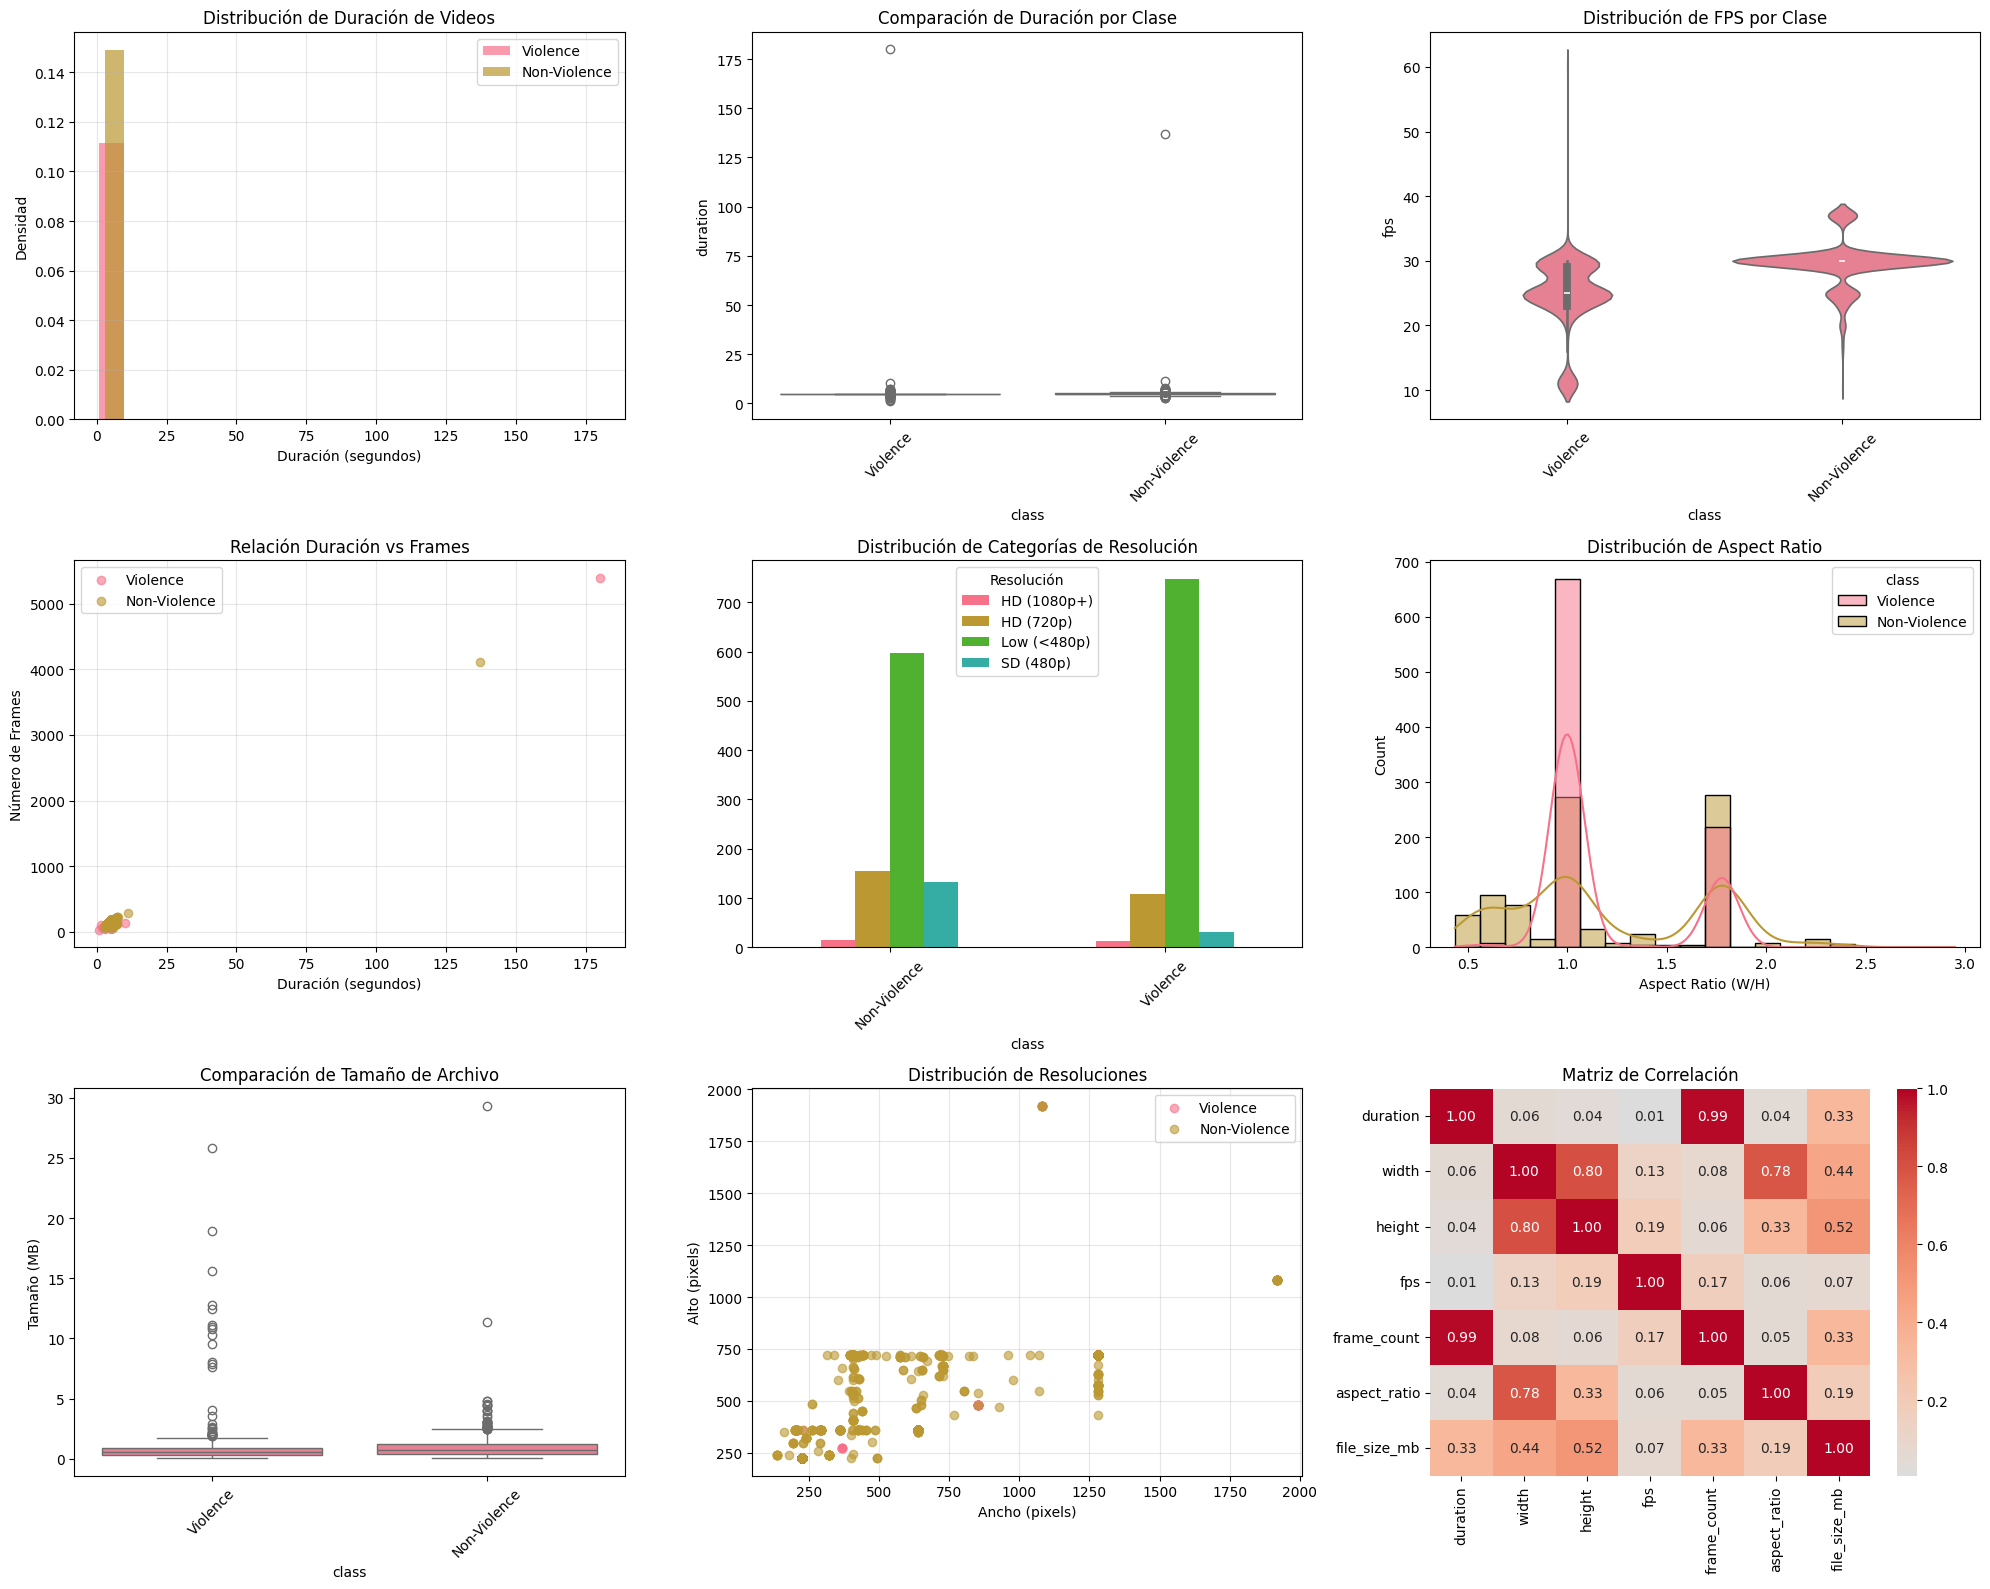


🔍 ANÁLISIS DE RESOLUCIONES:

Resoluciones más comunes:
  224x224: 849 videos (47.2%)
  1280x720: 262 videos (14.6%)
  640x360: 172 videos (9.6%)
  360x360: 44 videos (2.4%)
  854x480: 32 videos (1.8%)
  202x360: 23 videos (1.3%)
  1920x1080: 20 videos (1.1%)
  406x720: 18 videos (1.0%)
  292x360: 17 videos (0.9%)
  320x240: 16 videos (0.9%)

Distribución por categoría de resolución:

Violence:
  Low (<480p): 748 videos (83.1%)
  HD (720p): 108 videos (12.0%)
  SD (480p): 31 videos (3.4%)
  HD (1080p+): 13 videos (1.4%)

Non-Violence:
  Low (<480p): 598 videos (66.4%)
  HD (720p): 154 videos (17.1%)
  SD (480p): 132 videos (14.7%)
  HD (1080p+): 16 videos (1.8%)

🖼️ Generando muestras visuales...


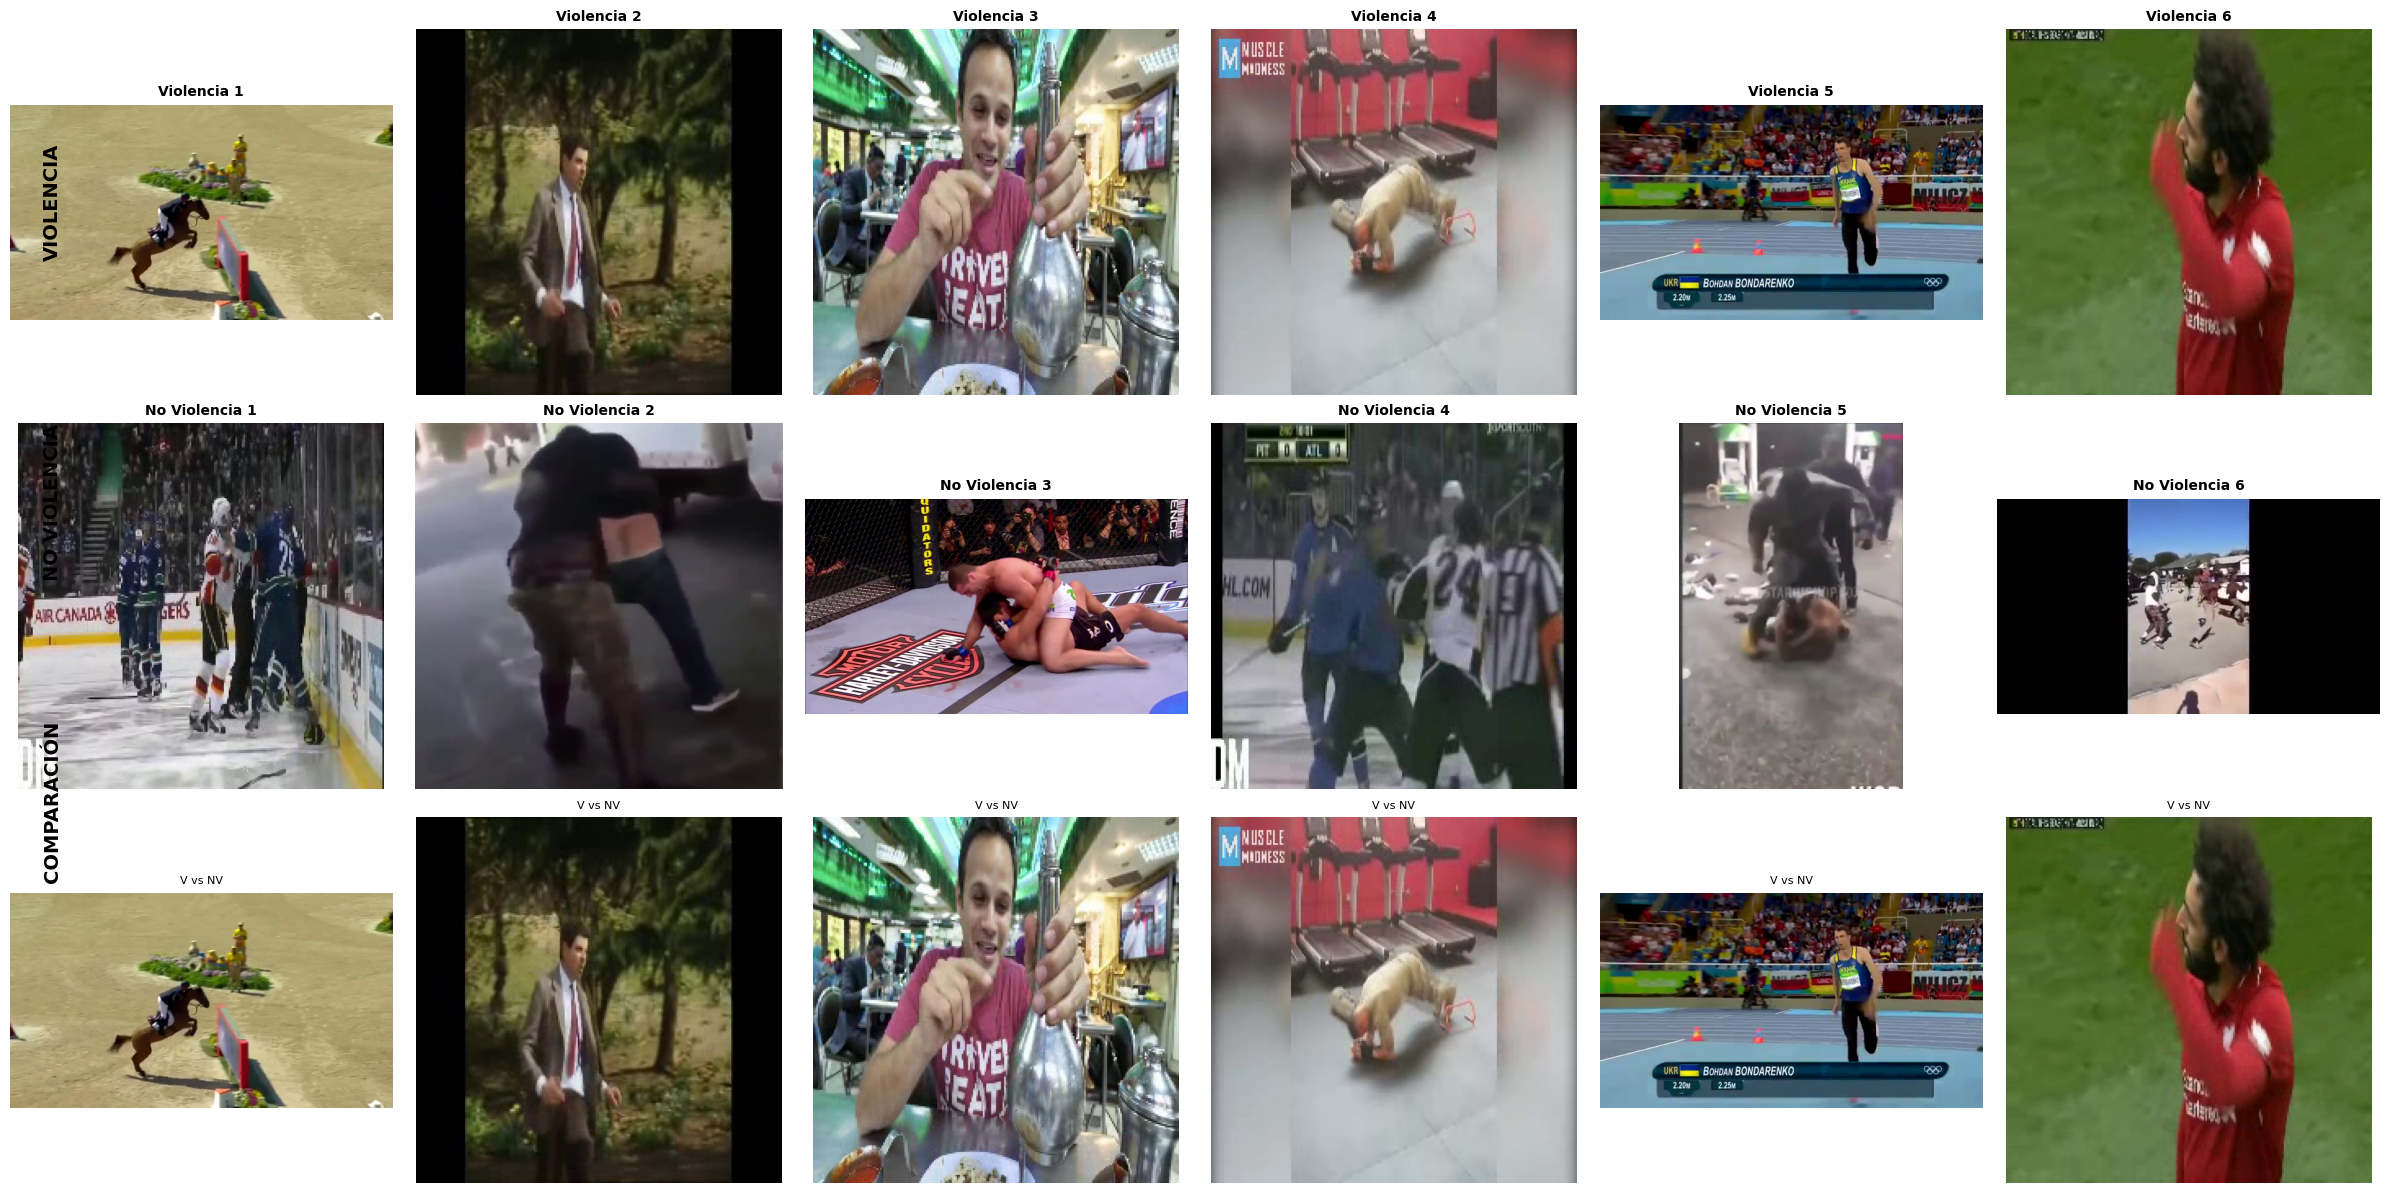


⏱️ ANÁLISIS TEMPORAL:

Violence:
  Duración promedio: 5.11 ± 5.85 segundos
  Frames promedio: 127 ± 178
  FPS promedio: 24.72 ± 5.40
  Videos cortos (<3s): 6 (0.7%)
  Videos medianos (3-8s): 892 (99.1%)
  Videos largos (>8s): 2 (0.2%)

Non-Violence:
  Duración promedio: 5.05 ± 4.45 segundos
  Frames promedio: 149 ± 135
  FPS promedio: 29.55 ± 3.54
  Videos cortos (<3s): 0 (0.0%)
  Videos medianos (3-8s): 898 (99.8%)
  Videos largos (>8s): 2 (0.2%)

🎯 HALLAZGOS CLAVE DEL EDA
📊 BALANCE DEL DATASET:
├── Videos de violencia: 951
├── Videos de no violencia: 1000
└── Ratio de balance: 0.95 (✅ Balanceado)

⏱️ CARACTERÍSTICAS TEMPORALES:
├── Duración promedio: 5.08 segundos
├── FPS promedio: 27.14
└── Frames promedio: 138

🎥 CARACTERÍSTICAS VISUALES:
├── Resolución más común: 224x224
├── Aspect ratio promedio: 1.20
└── Tamaño promedio: 0.9 MB

🔍 DIFERENCIAS ENTRE CLASES:
├── Diferencia en duración: +0.06 segundos
├── Diferencia en FPS: -4.82
└── Diferencia en tamaño: -0.2 MB

💡 RECOMENDACIONE

In [3]:
video_df = explore_video_dataset_improved(
        violence_path="/root/jsgutierrez/Real_Life_Violence_Dataset/NonViolence",
        non_violence_path="/root/jsgutierrez/Real_Life_Violence_Dataset/Violence",
        sample_size=900
    )

In [4]:
from utils import IntelligentVideoSplit
splitter = IntelligentVideoSplit(
        src_dir="/root/jsgutierrez/Real_Life_Violence_Dataset/",
        dest_dir="/root/jsgutierrez/dataset_optimized",
        train_ratio=0.80,  # Maximizar datos de entrenamiento
        val_ratio=0.15,
        test_ratio=0.05,
        stratify_by_duration=True,
        seed=42
    )
    
splitter.create_intelligent_split()

🧠 Creando split inteligente...
📊 Clips potenciales totales: 7753
  Violence: 4407 clips
  NonViolence: 3346 clips

📋 REPORTE DE SPLIT OPTIMIZADO:

TRAIN (75%):
  Violence:
    Videos: 750
    Clips potenciales: 3299
  NonViolence:
    Videos: 750
    Clips potenciales: 2399

VAL (15%):
  Violence:
    Videos: 150
    Clips potenciales: 587
  NonViolence:
    Videos: 150
    Clips potenciales: 495

TEST (10%):
  Violence:
    Videos: 100
    Clips potenciales: 390
  NonViolence:
    Videos: 100
    Clips potenciales: 330


In [5]:
from utils import get_maximal_optimized_loaders

train_loader, val_loader, test_loader = get_maximal_optimized_loaders(
        dataset_dir="/root/jsgutierrez/dataset_optimized",
        batch_size=4,
        num_frames=32,
        overlap_ratio=0.3,  # 30% overlap para más datos
        fps_standardization=True,
        target_fps=25  # Standardizar FPS
    )

🚀 Creando DataLoaders con máxima optimización...
🔧 Inicializando train dataset...
   📹 Videos: 1461
   🎬 Clips generados: 6953
   📊 Ratio clips/video: 4.76
✅ train dataset: 6953 samples generados
🔧 Inicializando val dataset...
   📹 Videos: 291
   🎬 Clips generados: 1148
   📊 Ratio clips/video: 3.95
✅ val dataset: 1148 samples generados
🔧 Inicializando test dataset...
   📹 Videos: 199
   🎬 Clips generados: 597
   📊 Ratio clips/video: 3.00
✅ test dataset: 597 samples generados

📊 DATASET CON MÁXIMA OPTIMIZACIÓN:
├── Train: 6953 samples (1739 batches)
├── Val: 1148 samples (287 batches)
└── Test: 597 samples (150 batches)

🎯 Total samples: 8698
🎯 Mejora vs conservador: +2462 samples


In [6]:
for videos, labels in train_loader:
    print("Batch shape:", videos.shape)  # [B, C, T, H, W]
    print("Labels:", labels)
    break

Batch shape: torch.Size([4, 3, 32, 224, 224])
Labels: tensor([1, 0, 0, 1])


In [7]:
print(f"Train dataset size: {len(train_loader)}")
print(f"Validation dataset size: {len(val_loader)}")
print(f"Test dataset size: {len(test_loader)}")

Train dataset size: 1739
Validation dataset size: 287
Test dataset size: 150


🚀 Using device: cuda
📊 Model parameters: 4,610
🎯 Starting training for 20 epochs...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


  Batch 100/1372 | Loss: 0.4240 | Acc: 67.57%
  Batch 200/1372 | Loss: 0.2217 | Acc: 73.38%
  Batch 300/1372 | Loss: 0.6606 | Acc: 77.74%
  Batch 400/1372 | Loss: 0.3222 | Acc: 79.49%
  Batch 500/1372 | Loss: 0.8175 | Acc: 80.99%
  Batch 600/1372 | Loss: 0.2741 | Acc: 81.86%
  Batch 700/1372 | Loss: 0.2512 | Acc: 82.42%
  Batch 800/1372 | Loss: 0.3006 | Acc: 82.83%
  Batch 900/1372 | Loss: 1.2307 | Acc: 83.21%
  Batch 1000/1372 | Loss: 0.4033 | Acc: 83.64%
  Batch 1100/1372 | Loss: 0.7448 | Acc: 83.63%
  Batch 1200/1372 | Loss: 0.5013 | Acc: 83.93%
  Batch 1300/1372 | Loss: 0.2983 | Acc: 84.24%
Epoch 1/20 | Train Loss: 0.4458 Acc: 84.55% | Val Loss: 0.4810 Acc: 85.07% | LR: 0.001000
✅ Checkpoint guardado en 'best_model.pth' (epoch=0, metric=85.0694)
🎯 New best model saved! Val Loss: 0.4810, Val Acc: 85.07%
----------------------------------------------------------------------
  Batch 100/1372 | Loss: 0.2717 | Acc: 87.87%
  Batch 200/1372 | Loss: 0.5459 | Acc: 86.69%
  Batch 300/1372 | 

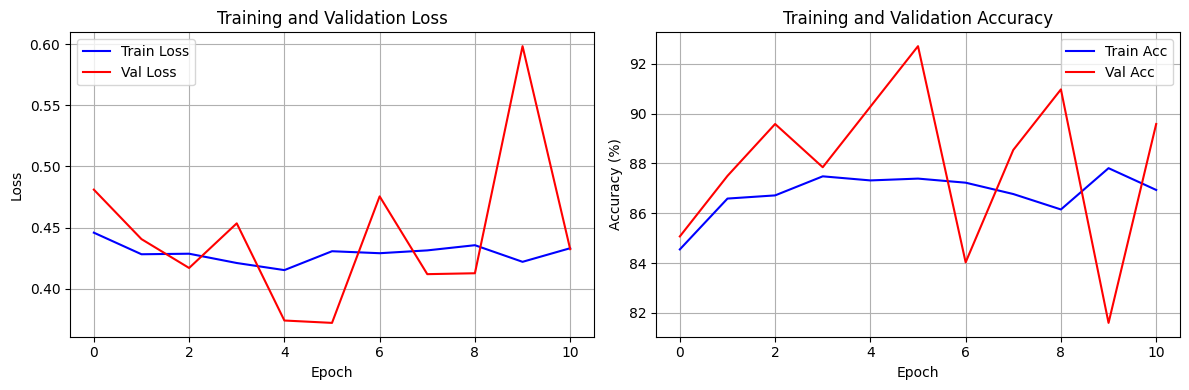

📊 Training curves saved as 'training_curves.png'
✅ Training script completed successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import SlowFastClassifier, save_checkpoint
import numpy as np

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Crear modelo
model = SlowFastClassifier(num_classes=2, freeze_backbone=True).to(device)
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Configuración del entrenamiento
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ✅ CAMBIO: Usar ReduceLROnPlateau es mejor para validación
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, verbose=True
)

# Early stopping setup
best_val_loss = np.inf
best_val_acc = 0.0  # ✅ AÑADIDO: Trackear mejor accuracy también
patience = 5  # ✅ CAMBIO: Más paciencia (3->5)
trigger_times = 0

# ✅ AÑADIDO: Tracking de métricas
train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 20
print(f"🎯 Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # ✅ AÑADIDO: Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # ✅ AÑADIDO: Progress tracking cada 100 batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            current_acc = correct / total * 100
            print(f"  Batch {batch_idx}/{len(train_loader)} | "
                  f"Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%")
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total * 100
    
    # ==================== VALIDATION ====================
    model.eval()
    running_loss_eval, correct_eval, total_eval = 0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss_eval += loss.item()
            predicted = outputs.argmax(dim=1)
            correct_eval += (predicted == labels).sum().item()
            total_eval += labels.size(0)
    
    val_loss = running_loss_eval / len(val_loader)
    val_acc = correct_eval / total_eval * 100
    
    # ✅ CAMBIO: Scheduler debe recibir val_loss para ReduceLROnPlateau
    scheduler.step(val_loss)
    
    # ✅ AÑADIDO: Almacenar métricas para análisis
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # ✅ MEJORADO: Mostrar learning rate actual
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.6f}")
    
    # ==================== EARLY STOPPING & CHECKPOINTING ====================
    # ✅ MEJORADO: Criterio de mejora (loss menor)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        trigger_times = 0
        save_checkpoint(model, optimizer, epoch, val_acc, path="best_model.pth")
        print(f"🎯 New best model saved! Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    else:
        trigger_times += 1
        print(f"⚠️ EarlyStopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break
    
    # ✅ AÑADIDO: Checkpoint cada 5 epochs (backup)
    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch, val_acc, path=f"checkpoint_epoch_{epoch+1}.pth")
    
    print("-" * 70)

# ==================== TRAINING SUMMARY ====================
print(f"\n🏁 Training completed!")
print(f"📈 Best validation loss: {best_val_loss:.4f}")
print(f"🎯 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📊 Total epochs trained: {len(train_losses)}")

# ✅ AÑADIDO: Guardar métricas para análisis posterior
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc
}

# Guardar historial
torch.save(training_history, 'training_history.pth')
print("📄 Training history saved to 'training_history.pth'")

# ✅ AÑADIDO: Visualización opcional de métricas
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='blue')
    plt.plot(val_accs, label='Val Acc', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Training curves saved as 'training_curves.png'")
    
except ImportError:
    print("⚠️ Matplotlib not available. Skipping visualization.")

print("✅ Training script completed successfully!")

✅ Checkpoint cargado desde 'best_model.pth' (epoch=5, metric=92.7083)

✅ Video aleatorio del test:
👉 Label real: Violence
🚀 Predicción: Violence
🎯 Confianza: 95.7%


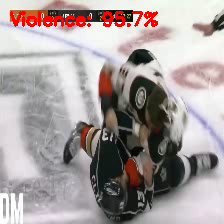

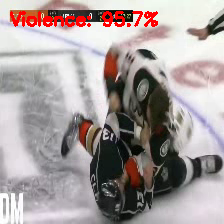

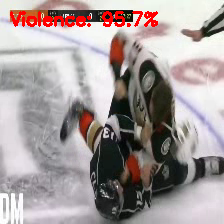

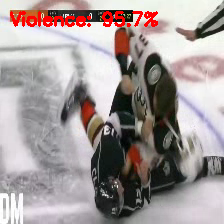

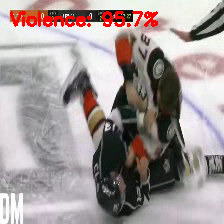

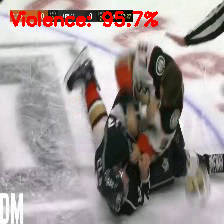

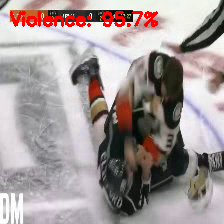

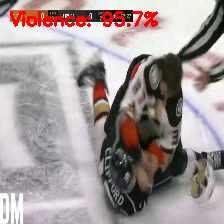

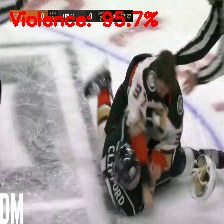

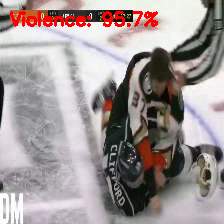

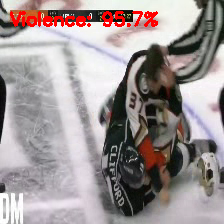

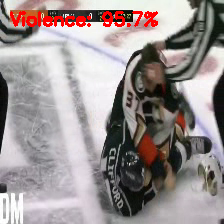

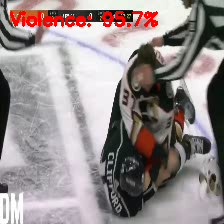

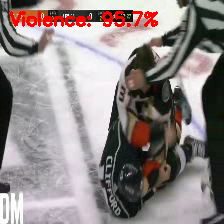

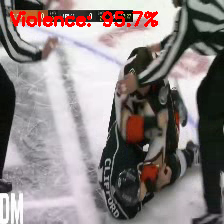

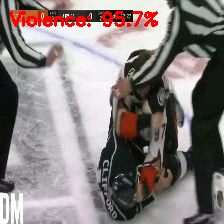

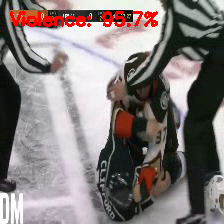

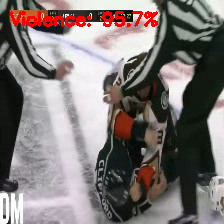

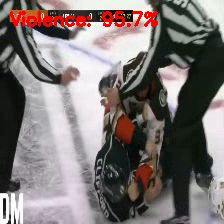

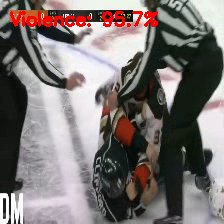

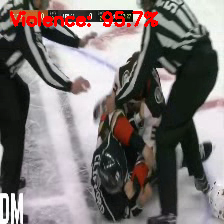

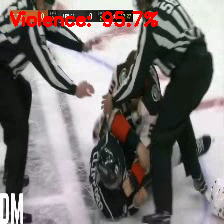

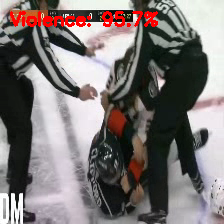

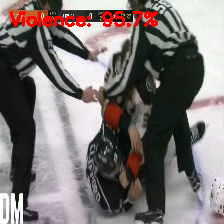

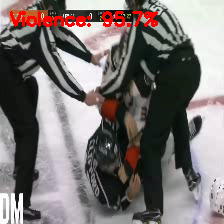

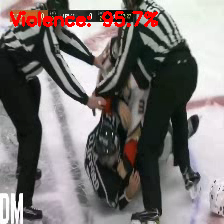

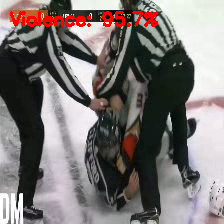

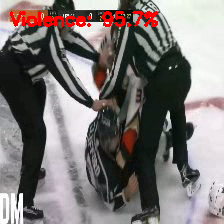

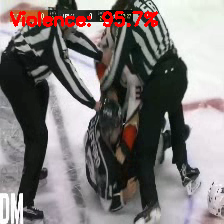

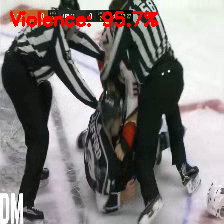

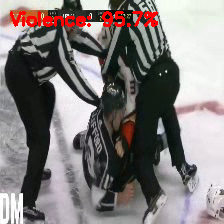

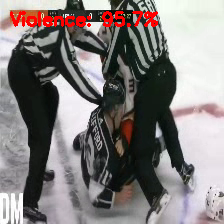

✅ Video guardado como 'output.mp4'


In [24]:
import torch
from torch.utils.data import DataLoader
import random
from models import SlowFastClassifier, load_model
from utils import VideoDatasetSlowFastFixed
from torchvision.transforms import v2
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform igual al val/test
transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

# Dataset
test_dataset = VideoDatasetSlowFastFixed(
    root_dir="./dataset_split/test",
    num_frames=32,
    img_size=224,
    transform=transform
)

# Modelo
model = SlowFastClassifier(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
_, _ = load_model(model, optimizer, path="best_model.pth", device=device)
model.eval()

# Invertir idx->class
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# Video aleatorio del test
video_idx = random.randint(0, len(test_dataset)-1)
video_frames, true_label = test_dataset[video_idx]
video_frames = video_frames.unsqueeze(0).to(device)

# Predicción
with torch.no_grad():
    outputs = model(video_frames)
    softmax = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_class = outputs.argmax(dim=1).item()

pred_label = idx_to_class[pred_class]
confidence = softmax[pred_class] * 100

print("\n✅ Video aleatorio del test:")
print(f"👉 Label real: {idx_to_class[true_label]}")
print(f"🚀 Predicción: {pred_label}")
print(f"🎯 Confianza: {confidence:.1f}%")

# Reconstruir frames
frames_np = video_frames.squeeze(0).permute(1,2,3,0).cpu().numpy()
frames_np = (frames_np * np.array([0.229,0.224,0.225])[None,None,None,:] +
             np.array([0.485,0.456,0.406])[None,None,None,:])
frames_np = np.clip(frames_np * 255, 0, 255).astype(np.uint8)

# Configurar video writer
height, width = frames_np.shape[1], frames_np.shape[2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_out = cv2.VideoWriter('output.mp4', fourcc, 5, (width, height))  # 5 FPS

# Mostrar frames + escribir video
for i, frame in enumerate(frames_np):
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    label_text = f"{pred_label}: {confidence:.1f}%"
    color = (0,0,255) if pred_class==1 else (0,255,0)
    cv2.putText(frame_bgr, label_text, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, color, 2)  # Letra más pequeña
    cv2_imshow(frame_bgr)
    video_out.write(frame_bgr)

video_out.release()
print("✅ Video guardado como 'output.mp4'")


In [30]:
def detect_violence_simple(video_path, model, transform, device, output_path="detection_output.mp4"):
    """
    Función sencilla para detectar violencia con sliding window
    """
    
    window_size = 32
    stride = 16
    
    print(f"🎬 Procesando video: {video_path}")
    
    # Leer frames originales
    cap = cv2.VideoCapture(video_path)
    original_frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        original_frames.append(frame)
    
    cap.release()
    
    if len(original_frames) < window_size:
        print(f"❌ Video muy corto: {len(original_frames)} frames (mínimo {window_size})")
        return
    
    print(f"📹 Frames cargados: {len(original_frames)}")
    
    # Configurar video de salida
    height, width = original_frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))
    
    # Procesar con sliding window
    predictions = []
    model.eval()
    
    print("🔍 Analizando video...")
    
    for start in range(0, len(original_frames) - window_size + 1, stride):
        end = start + window_size
        
        # Preparar clip para el modelo
        clip_frames = []
        for i in range(start, end):
            frame = original_frames[i]
            # BGR -> RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # A tensor [H, W, C] -> [C, H, W]
            frame_tensor = torch.from_numpy(frame_rgb).permute(2, 0, 1)
            clip_frames.append(frame_tensor)
        
        # Stack frames [T, C, H, W]
        clip_tensor = torch.stack(clip_frames)
        
        # Aplicar transform frame por frame
        transformed_frames = []
        for frame in clip_tensor:
            transformed_frame = transform(frame)
            transformed_frames.append(transformed_frame)
        
        # Preparar para modelo [C, T, H, W]
        input_tensor = torch.stack(transformed_frames).permute(1, 0, 2, 3).unsqueeze(0).to(device)
        
        # Predicción
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)[0]
            pred_class = outputs.argmax(dim=1).item()
            confidence = probs[pred_class].item() * 100
        
        # Guardar predicción
        label = "Violence" if pred_class == 1 else "NonViolence"
        predictions.append({
            'start': start,
            'end': end,
            'label': label,
            'confidence': confidence,
            'class': pred_class
        })
        
        print(f"  Frames {start:3d}-{end:3d}: {label} ({confidence:.1f}%)")
    
    # Crear video anotado
    print("🎨 Creando video anotado...")
    
    for frame_idx, frame in enumerate(original_frames):
        # Encontrar predicción para este frame
        current_pred = None
        for pred in predictions:
            if pred['start'] <= frame_idx < pred['end']:
                current_pred = pred
                break
        
        # Anotar frame
        annotated_frame = frame.copy()
        
        if current_pred:
            label = current_pred['label']
            confidence = current_pred['confidence']
            pred_class = current_pred['class']
            
            # Color según predicción
            color = (0, 0, 255) if pred_class == 1 else (0, 255, 0)  # Rojo o Verde
            bg_color = (0, 0, 128) if pred_class == 1 else (0, 128, 0)  # Fondo oscuro
            
            # Texto
            text = f"{label}: {confidence:.1f}%"
            
            # Fondo del texto
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            thickness = 2
            (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)
            
            cv2.rectangle(annotated_frame, (10, 10), (10 + text_w + 10, 10 + text_h + 10), bg_color, -1)
            cv2.putText(annotated_frame, text, (15, 10 + text_h), font, font_scale, color, thickness)
            
            # Borde si es violencia
            if pred_class == 1:
                cv2.rectangle(annotated_frame, (0, 0), (width-1, height-1), (0, 0, 255), 8)
        
        video_out.write(annotated_frame)
    
    video_out.release()
    
    # Resumen
    violence_count = sum(1 for p in predictions if p['class'] == 1)
    total_predictions = len(predictions)
    
    print(f"\n✅ Procesamiento completado!")
    print(f"📊 Resultado: {violence_count}/{total_predictions} ventanas con violencia")
    print(f"📁 Video guardado: {output_path}")
    
    return predictions


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = SlowFastClassifier(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
_, _ = load_model(model, optimizer, path="best_model.pth", device=device)
model.eval()

# Usar la función
video_path = "/root/jsgutierrez/demo.mp4"
predictions = detect_violence_simple(video_path, model, transform, device)

✅ Checkpoint cargado desde 'best_model.pth' (epoch=5, metric=92.7083)
🎬 Procesando video: /root/jsgutierrez/demo.mp4
📹 Frames cargados: 4380
🔍 Analizando video...
  Frames   0- 32: Violence (83.3%)
  Frames  16- 48: Violence (61.5%)
  Frames  32- 64: Violence (72.9%)
  Frames  48- 80: Violence (54.2%)
  Frames  64- 96: Violence (58.2%)
  Frames  80-112: Violence (57.6%)
  Frames  96-128: Violence (59.9%)
  Frames 112-144: Violence (57.7%)
  Frames 128-160: Violence (62.9%)
  Frames 144-176: Violence (61.5%)
  Frames 160-192: Violence (61.7%)
  Frames 176-208: Violence (78.1%)
  Frames 192-224: Violence (88.4%)
  Frames 208-240: NonViolence (78.5%)
  Frames 224-256: NonViolence (86.9%)
  Frames 240-272: NonViolence (60.0%)
  Frames 256-288: NonViolence (53.7%)
  Frames 272-304: NonViolence (55.6%)
  Frames 288-320: NonViolence (51.3%)
  Frames 304-336: Violence (60.1%)
  Frames 320-352: Violence (54.1%)
  Frames 336-368: Violence (63.5%)
  Frames 352-384: Violence (51.0%)
  Frames 368-4

In [29]:
def create_sliding_window_video(video_path, model, transform, device, output_path="output_detection.mp4"):
    """
    Crea video con detección de violencia usando sliding window
    """
    
    window_size = 32
    stride = 16  # Ajustable para más o menos solapamiento
    
    # Leer todos los frames originales (SIN transformar)
    original_frames = []
    cap = cv2.VideoCapture(video_path)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Guardar frame original en BGR para video output
        original_frames.append(frame.copy())
    
    cap.release()
    
    if len(original_frames) == 0:
        print("❌ No se pudieron leer frames del video")
        return
    
    print(f"📹 Video cargado: {len(original_frames)} frames")
    
    # Configuración del video de salida
    height, width = original_frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 30
    video_out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    idx_to_class = {0: "NonViolence", 1: "Violence"}
    model.eval()
    
    # Procesar video con sliding window
    predictions = []
    
    for start in range(0, len(original_frames) - window_size + 1, stride):
        end = start + window_size
        clip_frames = original_frames[start:end]
        
        # Preparar clip para el modelo
        processed_clip = prepare_clip_for_model(clip_frames, transform, device)
        
        # Realizar predicción
        with torch.no_grad():
            outputs = model(processed_clip)
            softmax = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
            pred_class = outputs.argmax(dim=1).item()
        
        pred_label = idx_to_class[pred_class]
        confidence = softmax[pred_class] * 100
        
        # Guardar predicción para este segmento
        predictions.append({
            'start': start,
            'end': end,
            'label': pred_label,
            'confidence': confidence,
            'class': pred_class
        })
        
        print(f"Ventana {start:3d}-{end:3d}: {pred_label} ({confidence:.1f}%)")
    
    # Crear video con anotaciones
    create_annotated_video(original_frames, predictions, video_out, window_size, stride)
    
    video_out.release()
    print(f"✅ Video con detección guardado: '{output_path}'")
    
    return predictions


def prepare_clip_for_model(clip_frames, transform, device):
    """
    Prepara clip de frames para el modelo
    """
    processed_frames = []
    
    for frame in clip_frames:
        # Convertir BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convertir a tensor
        frame_tensor = torch.from_numpy(frame_rgb).permute(2, 0, 1).float() / 255.0
        
        # Aplicar transformaciones
        frame_transformed = transform(frame_tensor)
        processed_frames.append(frame_transformed)
    
    # Stack y preparar para el modelo
    clip_tensor = torch.stack(processed_frames)  # [T, C, H, W]
    clip_tensor = clip_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # [1, C, T, H, W]
    
    return clip_tensor.to(device)


def create_annotated_video(original_frames, predictions, video_out, window_size, stride):
    """
    Crea video anotado con predicciones
    """
    # Mapear predicciones a frames individuales
    frame_predictions = assign_predictions_to_frames(original_frames, predictions, window_size, stride)
    
    # Escribir frames anotados
    for i, frame in enumerate(original_frames):
        annotated_frame = annotate_frame(frame.copy(), frame_predictions[i])
        video_out.write(annotated_frame)


def assign_predictions_to_frames(original_frames, predictions, window_size, stride):
    """
    Asigna predicciones a frames individuales usando voting o averaging
    """
    frame_predictions = []
    
    for frame_idx in range(len(original_frames)):
        # Encontrar todas las ventanas que incluyen este frame
        relevant_predictions = []
        
        for pred in predictions:
            if pred['start'] <= frame_idx < pred['end']:
                relevant_predictions.append(pred)
        
        if relevant_predictions:
            # Estrategia: usar la predicción con mayor confianza
            best_pred = max(relevant_predictions, key=lambda x: x['confidence'])
            frame_predictions.append(best_pred)
        else:
            # Frame sin predicción (inicio/final del video)
            frame_predictions.append({
                'label': 'Unknown',
                'confidence': 0.0,
                'class': -1
            })
    
    return frame_predictions


def annotate_frame(frame, prediction):
    """
    Anota un frame individual con la predicción
    """
    label = prediction['label']
    confidence = prediction['confidence']
    pred_class = prediction['class']
    
    # Colores para las clases
    if pred_class == 1:  # Violence
        color = (0, 0, 255)  # Rojo
        bg_color = (0, 0, 128)  # Rojo oscuro para fondo
    elif pred_class == 0:  # NonViolence
        color = (0, 255, 0)  # Verde
        bg_color = (0, 128, 0)  # Verde oscuro para fondo
    else:  # Unknown
        color = (128, 128, 128)  # Gris
        bg_color = (64, 64, 64)  # Gris oscuro para fondo
    
    # Texto a mostrar
    text = f"{label}: {confidence:.1f}%"
    
    # Configuración del texto
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 2
    
    # Calcular tamaño del texto
    (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    
    # Posición del texto
    x, y = 10, 30
    
    # Dibujar fondo del texto
    cv2.rectangle(frame, 
                  (x - 5, y - text_height - 10), 
                  (x + text_width + 5, y + baseline + 5), 
                  bg_color, -1)
    
    # Dibujar texto
    cv2.putText(frame, text, (x, y), font, font_scale, color, thickness)
    
    # Opcional: Dibujar borde del frame según la predicción
    if pred_class == 1:  # Violence
        cv2.rectangle(frame, (0, 0), (frame.shape[1]-1, frame.shape[0]-1), (0, 0, 255), 5)
    
    return frame


def advanced_sliding_window_detection(video_path, model, transform, device, 
                                     window_size=32, stride=8, 
                                     confidence_threshold=0.7):
    """
    Versión avanzada con smoothing y filtrado
    """
    
    # Obtener predicciones básicas
    predictions = create_sliding_window_video(
        video_path, model, transform, device, 
        f"temp_detection_{window_size}_{stride}.mp4"
    )
    
    # Aplicar smoothing temporal
    smoothed_predictions = apply_temporal_smoothing(predictions, window_size=5)
    
    # Filtrar por confianza
    filtered_predictions = filter_by_confidence(smoothed_predictions, confidence_threshold)
    
    # Crear video final con predicciones mejoradas
    create_final_video(video_path, filtered_predictions, 
                      f"final_detection_{window_size}_{stride}.mp4")
    
    return filtered_predictions


def apply_temporal_smoothing(predictions, window_size=5):
    """
    Aplica smoothing temporal para reducir flickering
    """
    if len(predictions) < window_size:
        return predictions
    
    smoothed = []
    
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(predictions), i + window_size // 2 + 1)
        
        # Promediar confianzas en la ventana
        window_preds = predictions[start_idx:end_idx]
        
        violence_confidences = [p['confidence'] if p['class'] == 1 else 0 
                               for p in window_preds]
        nonviolence_confidences = [p['confidence'] if p['class'] == 0 else 0 
                                  for p in window_preds]
        
        avg_violence = np.mean(violence_confidences)
        avg_nonviolence = np.mean(nonviolence_confidences)
        
        if avg_violence > avg_nonviolence:
            smoothed_pred = {
                'start': predictions[i]['start'],
                'end': predictions[i]['end'],
                'label': 'Violence',
                'confidence': avg_violence,
                'class': 1
            }
        else:
            smoothed_pred = {
                'start': predictions[i]['start'],
                'end': predictions[i]['end'],
                'label': 'NonViolence', 
                'confidence': avg_nonviolence,
                'class': 0
            }
        
        smoothed.append(smoothed_pred)
    
    return smoothed


def filter_by_confidence(predictions, threshold=0.7):
    """
    Filtra predicciones por nivel de confianza
    """
    filtered = []
    
    for pred in predictions:
        if pred['confidence'] >= threshold:
            filtered.append(pred)
        else:
            # Convertir a "uncertain"
            uncertain_pred = pred.copy()
            uncertain_pred['label'] = 'Uncertain'
            uncertain_pred['class'] = -1
            filtered.append(uncertain_pred)
    
    return filtered


# Función de uso fácil
def detect_violence_in_video(video_path, model, device, output_path=None):
    """
    Función principal para detectar violencia en video
    """
    
    # Transform para evaluación
    eval_transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if output_path is None:
        output_path = "violence_detection_output.mp4"
    
    print(f"🎯 Iniciando detección de violencia en: {video_path}")
    
    # Realizar detección con parámetros optimizados
    predictions = advanced_sliding_window_detection(
        video_path=video_path,
        model=model,
        transform=eval_transform,
        device=device,
        window_size=32,
        stride=16,  # 50% overlap
        confidence_threshold=0.6
    )
    
    print(f"✅ Detección completada. Resultados en: {output_path}")
    
    # Resumen de resultados
    violence_segments = [p for p in predictions if p['class'] == 1]
    if violence_segments:
        print(f"⚠️ Se detectaron {len(violence_segments)} segmentos de violencia")
        for seg in violence_segments:
            print(f"   Frames {seg['start']}-{seg['end']}: {seg['confidence']:.1f}% confianza")
    else:
        print("✅ No se detectó violencia en el video")
    
    return predictions


In [ ]:
model = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

results = detect_violence_in_video("path/to/video.mp4", model, device)

In [6]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np

def segment_persons_in_video(video_path, model_path='./yolov8n-seg.pt', conf_thresh=0.3, max_frames=32):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)
    frames_segmented = []
    frame_count = 0

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf=conf_thresh)[0]
        height, width = frame.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)

        if results.masks is not None:
            for i, seg in enumerate(results.masks.data):
                cls_id = int(results.boxes.cls[i])
                if cls_id == 0:  # persona
                    seg_np = seg.cpu().numpy()  # [h, w] en YOLO shape
                    seg_resized = cv2.resize(seg_np, (width, height), interpolation=cv2.INTER_NEAREST)
                    mask = np.logical_or(mask, seg_resized).astype(np.uint8)

        masked_frame = cv2.bitwise_and(frame, frame, mask=mask)
        frames_segmented.append(cv2.cvtColor(masked_frame, cv2.COLOR_BGR2RGB))
        frame_count += 1

    cap.release()
    return frames_segmented



0: 640x640 2 persons, 1 horse, 4.0ms
Speed: 1.8ms preprocess, 4.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 1 horse, 4.1ms
Speed: 1.6ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 persons, 1 horse, 4.1ms
Speed: 1.8ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 1 horse, 4.1ms
Speed: 1.6ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 1 horse, 4.1ms
Speed: 1.5ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 1 horse, 4.1ms
Speed: 1.5ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 persons, 1 horse, 4.1ms
Speed: 1.5ms preprocess, 4.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 1 horse, 4.1ms
Speed: 1.5ms preprocess,

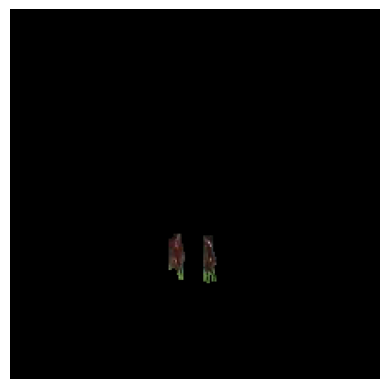

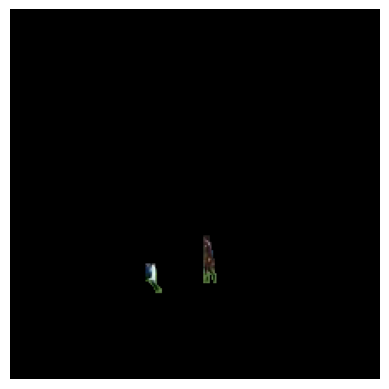

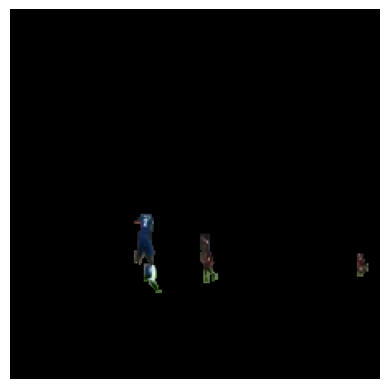

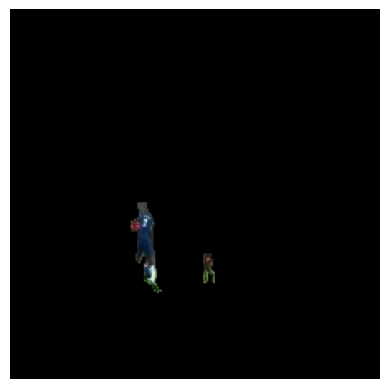

In [14]:
video_path = "/root/jsgutierrez/dataset_split/test/NonViolence/NV_72.mp4"
frames_segmented = segment_persons_in_video(video_path)

import matplotlib.pyplot as plt
for i in range(4):
    plt.imshow(frames_segmented[i])
    plt.axis("off")
    plt.show()
